<a href="https://colab.research.google.com/github/ACTCollaboration/DR6_Notebooks/blob/main/ACT_DR6_lensing_CIB_correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Correlation of the ACT CMB Lensing Maps with a Planck CIB map


*Written by Frank Qu and the ACT collaboration*

---

In this notebook we'll walk through how to load a lensing map from the ACT Data Release 6 (DR6). The lensing maps are actually released as `alms`, which can be filtered and converted to map space. The filtering and conversion process is demonstrated below. We also examine the correlation between the ACT lensing map and a Planck CIB map and demonstrate how two such maps can be compared.


The data for this release is publicly available on [Lambda](https://lambda.gsfc.nasa.gov/product/act/actadv_prod_table.html) and a full discussion of the ACT DR6 lensing analysis can be found in [Qu et al. (2023) ](https://arxiv.org/abs/2304.05202), [Madhavacheril et al. (2023)](https://arxiv.org/abs/2304.05203), [MacCrann et al. (2023)](https://arxiv.org/abs/2304.05196) and [Farren et al. (2023)](https://arxiv.org/pdf/2309.05659.pdf).

For anyone who would like a bit more background in CMB analysis we recommend a few other resources from ACT at the end of this notebook. In particular if you are unfarmiliar with [`pixell`](https://pixell.readthedocs.io/en/latest/) we recommend you refer to the `pixell` specific notebooks that demonstrate the basics of how to use the package.

In [ ]:
# We start by installing the relevant packages
%%capture
!pip install pixell
!pip install healpy
! pip install astropy

In [ ]:
from pixell import enmap, enplot, reproject, curvedsky as cs,utils
import healpy as hp
import numpy as np
from astropy.wcs import WCS


In [ ]:
# This is just a plotting function we will use to display the maps
def eshow(x,**kwargs):
    ''' Define a function to help us plot the maps neatly '''
    plots = enplot.get_plots(x, **kwargs)
    enplot.show(plots, method = "ipython")

In [ ]:
# Download the data needed for the notebook
# These includes the lensing map
# Planck CIB map at 545 GHz in MJy/sr
# BOSS survey

In [ ]:
!wget http://pla.esac.esa.int/pla/aio/product-action?MAP.MAP_ID=COM_CompMap_CIB-GNILC-F545_2048_R2.00.fits

!wget https://phy-act1.princeton.edu/public/data/dr6_lensing_v1/maps/baseline/mask_act_dr6_lensing_v1_healpix_nside_4096_baseline.fits

!wget https://phy-act1.princeton.edu/public/data/dr6_lensing_v1/misc/clkk.txt

!wget https://phy-act1.princeton.edu/public/data/dr6_lensing_v1/maps/baseline/N_L_kk_act_dr6_lensing_v1_baseline.txt

!wget https://phy-act1.princeton.edu/public/data/dr6_lensing_v1/maps/baseline/kappa_alm_data_act_dr6_lensing_v1_baseline.fits

--2024-04-17 15:25:02--  http://pla.esac.esa.int/pla/aio/product-action?MAP.MAP_ID=COM_CompMap_CIB-GNILC-F545_2048_R2.00.fits
Resolving pla.esac.esa.int (pla.esac.esa.int)... 193.147.153.153
Connecting to pla.esac.esa.int (pla.esac.esa.int)|193.147.153.153|:80... connected.
HTTP request sent, awaiting response... 200 
Length: unspecified [image/fits]
Saving to: ‘product-action?MAP.MAP_ID=COM_CompMap_CIB-GNILC-F545_2048_R2.00.fits’

product-action?MAP.     [              <=>   ] 192.01M  32.5MB/s    in 12s     

2024-04-17 15:25:15 (15.7 MB/s) - ‘product-action?MAP.MAP_ID=COM_CompMap_CIB-GNILC-F545_2048_R2.00.fits’ saved [201337920]

--2024-04-17 15:25:15--  https://phy-act1.princeton.edu/public/data/dr6_lensing_v1/maps/baseline/mask_act_dr6_lensing_v1_healpix_nside_4096_baseline.fits
Resolving phy-act1.princeton.edu (phy-act1.princeton.edu)... 128.112.102.238
Connecting to phy-act1.princeton.edu (phy-act1.princeton.edu)|128.112.102.238|:443... connected.
HTTP request sent, awaiting res

Let's load the ACT lensing analysis map. This is a binary mask apodized at the the edges with a cosine roll off.
The mask is in healpix, here we will convert this to CAR

In [ ]:
mask = hp.read_map('mask_act_dr6_lensing_v1_healpix_nside_4096_baseline.fits')

In [ ]:
box = np.array([[-63,180],[23,-180]]) * utils.degree
shape,wcs = enmap.geometry(pos=box,res=1 * utils.arcmin,proj='car')

In [ ]:
mask = reproject.healpix2map(mask, shape, wcs)

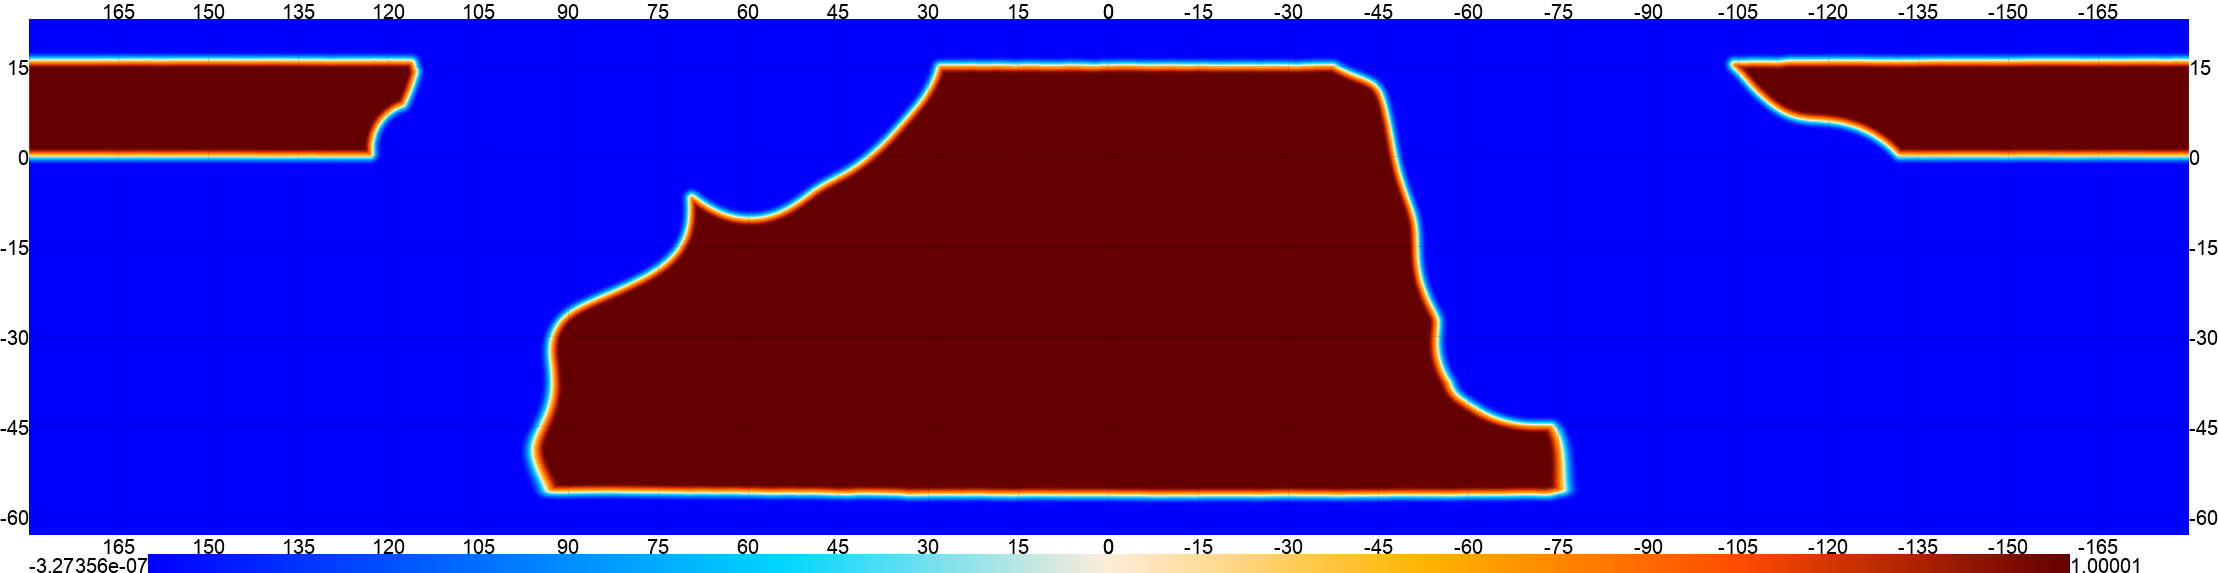

In [ ]:
eshow(mask, downgrade=10, colorbar=True, ticks=15)

The cosmic infrared background (CIB) map used here is the 545 GHz Planck CIB map obtained with component separation using the GNILC algorithm. See  arXiv:1905.00426 for details. The loaded CIB map is expressed in units of MJy sr${^{-1}}$, we convert that to $μK$ using the appropiate frequency conversion factor.



In [ ]:
cib = hp.fitsfunc.read_map('product-action?MAP.MAP_ID=COM_CompMap_CIB-GNILC-F545_2048_R2.00.fits')
cib_fact = 1.7508*10**4
cib *= cib_fact

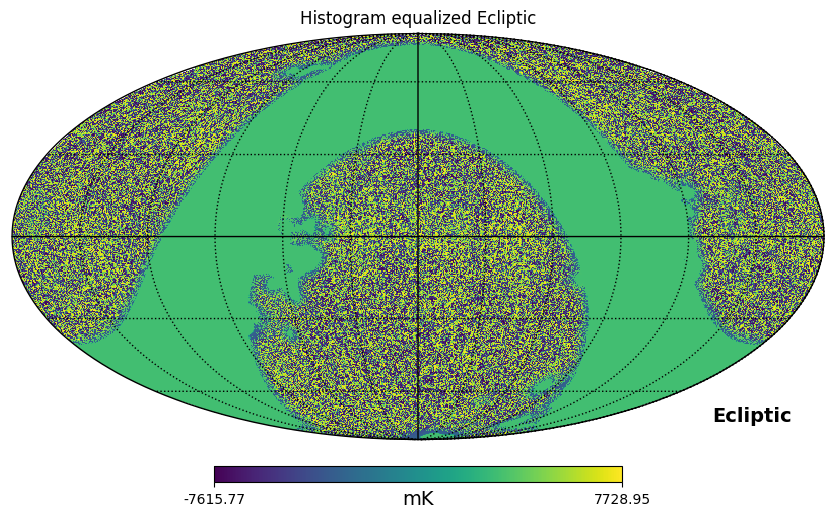

In [ ]:
hp.mollview(
    cib,
    coord=["G", "E"],
    title="Histogram equalized Ecliptic",
    unit="mK",
    norm="hist")
hp.graticule()

The CIB maps prepared by the *Planck* team are stored in healpix format in galactic coordinates. To correlate with the ACT lensing maps, we need to convert them to CAR format in equatorial coordinates.

In [ ]:
cib_map = reproject.healpix2map(np.double(cib), mask.shape, mask.wcs,lmax=3000,rot='gal,equ')

In [ ]:
cib_alms = cs.map2alm(cib_map,lmax=3000)

Now we load the DR6 kappa map, Wiener filter it and convert it from kappa to gravitational potential using the fact that $\kappa=-\frac{1}{2}\nabla^2\phi$.

In [ ]:
# Start by reading in the alms of the lensing map
kappa = hp.read_alm('kappa_alm_data_act_dr6_lensing_v1_baseline.fits')

# Convert any nans to avoid problems later on
kappa = np.nan_to_num(kappa)

# Load an input theory lensing power spectrum
clkk = np.loadtxt("clkk.txt")[:2101]

# Load the noise power spectrum which is a function of ell
ells,noise_kappa=np.loadtxt('N_L_kk_act_dr6_lensing_v1_baseline.txt',unpack=True)
#lets filter out the SNR dominated modes and obtain phi
#ells = np.arange(2099)
#noise_kappa=noise_kappa[:2099]
filter = np.nan_to_num(2*clkk/(clkk+noise_kappa)/ells**2)
filter[ells<100] = 0

<ipython-input-14-b98865c264a8>:15: RuntimeWarning: invalid value encountered in divide
  filter = np.nan_to_num(2*clkk/(clkk+noise_kappa)/ells**2)


In [ ]:
# We can now filter the kappa alms by the filter produced above
filter_kappa = hp.almxfl(kappa, filter)

In [ ]:
# We now convert the filtered alms to map space
frmap = cs.alm2map(filter_kappa, enmap.empty(mask.shape, mask.wcs))

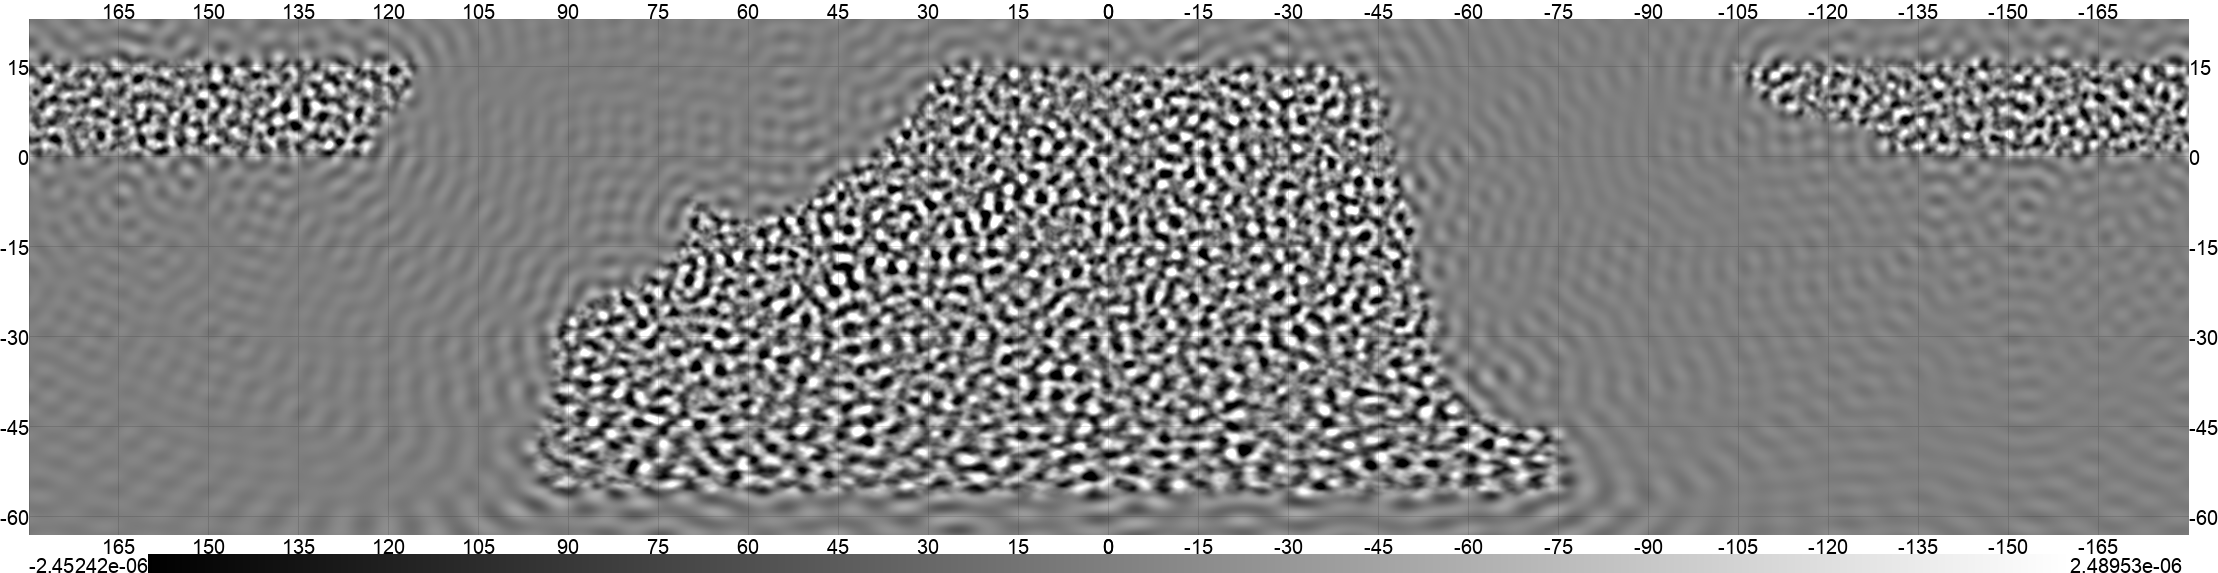

In [ ]:
eshow(frmap, downgrade=10, ticks=15, colorbar=True, color='gray')

 CMB lensing is a projected tracer of structure growth with sensitivity to structure at a wide range of redshifts. Our lensing map is signal dominated and traces the dark matter distribution with high fidelity, we therefore expect it to be highly correlated with structures of LSS, which covers a similar extend in redshift. One such tracer is the CIB, a faint glow of infrared radiation emitted by the stars from dusty forming galaxies. By applying the same filtering to the CIB, one can see the correlations by eye.

---



In [ ]:
# We apply the same filter the cib_alms as we did to the lensing map avove
fcib_alms = hp.almxfl(cib_alms, filter)


In [ ]:
# Again we can convert this to map space
filtercib = cs.alm2map(fcib_alms, enmap.empty(mask.shape, mask.wcs))

Here is the filtered CIB field, we can see that the structures here resembles the lensing map shown above.

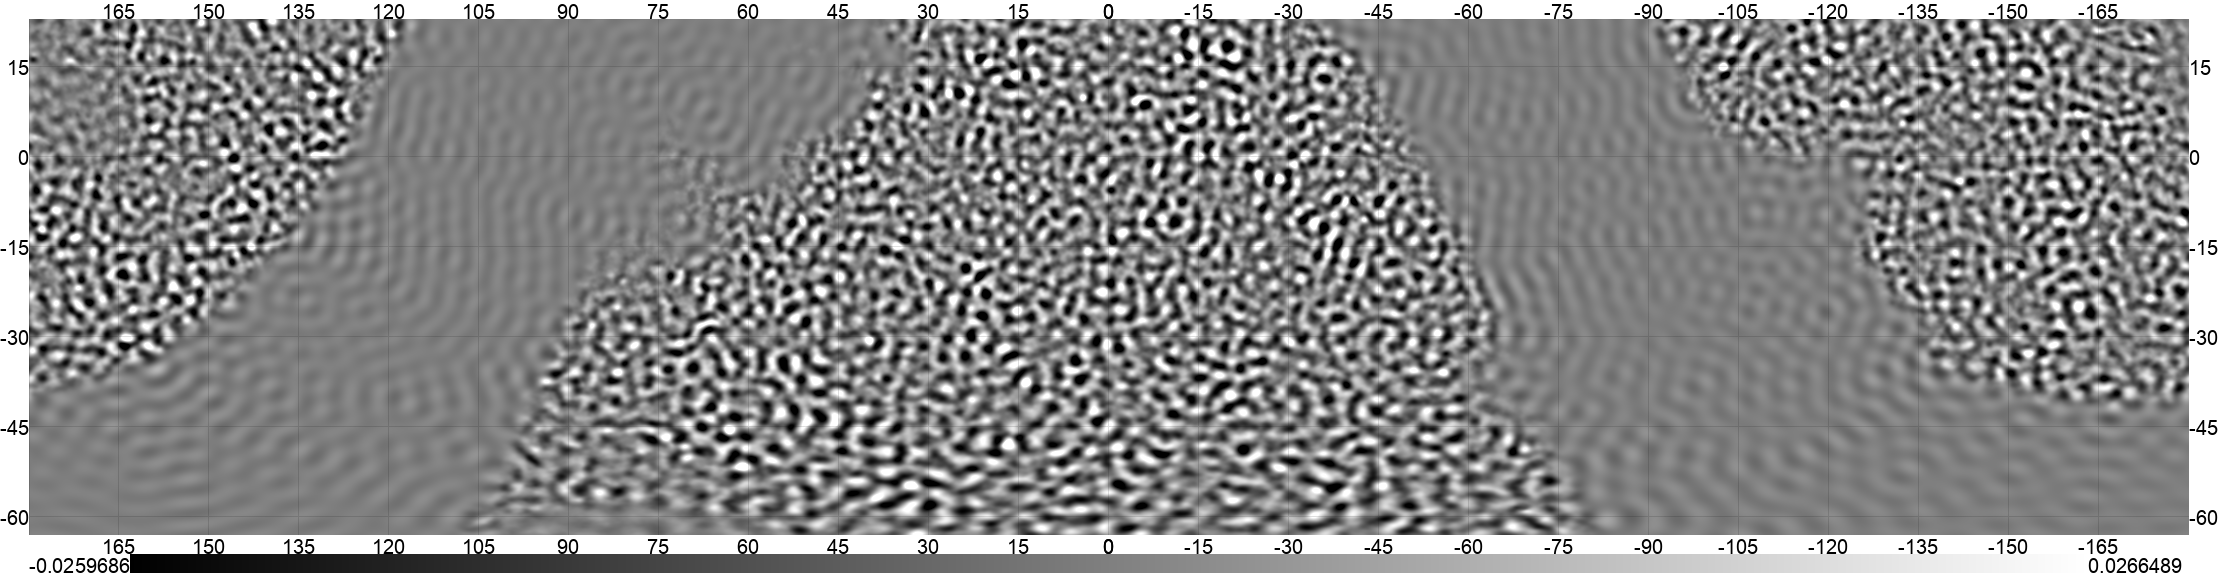

In [ ]:
eshow(filtercib, downgrade=10, ticks=15, colorbar=True, color='gray')

We can make the correspondence between the above two maps more apparent by overlying  the CIB as contours on top of the lensing map. First lets normalize the CIB so that the values are between 0 and 1.

In [ ]:
from sklearn import preprocessing as p
min_max_scaler = p.MinMaxScaler()
normalizedData = min_max_scaler.fit_transform(filtercib)
downgrade_factor = 5

In [ ]:
normalizedData = enmap.ndmap(normalizedData, mask.wcs)

Next we plot the normalized CIB as contours, with high intensity regions in red and low intensity regions in blue. The lensing map is plotted in black and white.

In [ ]:
p1 = enplot.plot(frmap, layers=True, ticks=15, downgrade=downgrade_factor, font_size=20, color='gray')
mask = np.piecewise(mask, [mask>=0.9,mask<0.5], [1, 0])

p2 = enplot.plot(normalizedData*mask, layers=True, contours="0.2", contour_width=1,
                 contour_color="1.:FF0000,0.9:e84e0c,0.8:e8730c,0.7:d9a509,0.6:d6c122,0.5:faff66,0.4:66ffa8,0.3:0083FE,0.2:5175ed,0.1:0400FE",
                 ticks=1, downgrade=downgrade_factor, font_size=20, mask=0)
p1 += [a for a in p2 if "cont" in a.name]
img = enplot.merge_images([a.img for a in p1])


/usr/local/lib/python3.10/dist-packages/pixell/array_ops.py:15: RuntimeWarning: invalid value encountered in cast
  omap = imap.astype(np.int32)*0


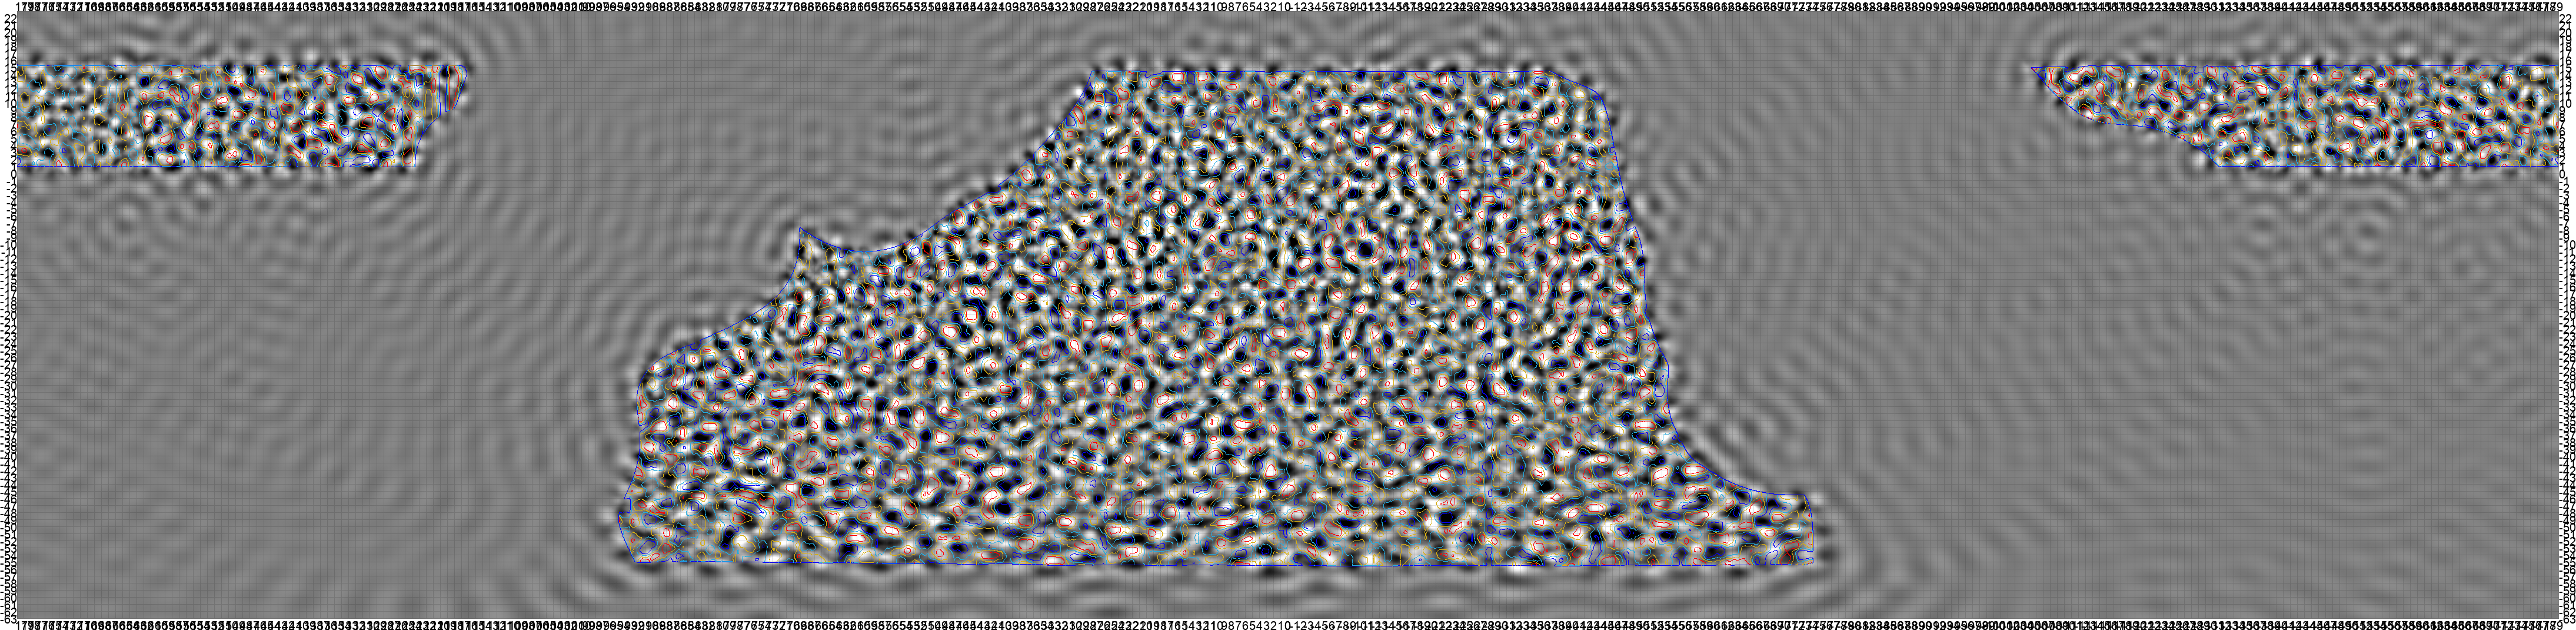

In [ ]:
# We can now plot the contours of each map and look at the correlation by eye.
enplot.show(img, method="ipython")

Zoom in to see a smaller patch

In [ ]:
# [[decfrom, rafrom], [[decto, rato]]
dec, ra = np.deg2rad(np.array((-45, -40.5)))
width = np.deg2rad(20)
box = np.array([[dec - width/2., ra - width/2.], [dec + width/2., ra + width/2.]])
stamp = frmap.submap(box)
mask_stamp = mask.submap(box)
normalizedData_stamp = normalizedData.submap(box)

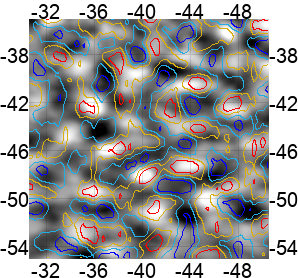

In [ ]:
p1 = enplot.plot(stamp, layers=True, ticks=4, downgrade=downgrade_factor, font_size=20, color='gray')
mask_stamp[mask_stamp!=1] = 0
p2 = enplot.plot(mask_stamp*normalizedData_stamp, layers=True, contours="0.2", contour_width=1,
                 contour_color="1.:FF0000,0.9:e84e0c,0.8:e8730c,0.7:d9a509,0.6:d6c122,0.5:faff66,0.4:66ffa8,0.3:0083FE,0.2:5175ed,0.1:0400FE",
                 ticks=1, downgrade=downgrade_factor, font_size=20, mask=0)
p1 += [a for a in p2 if "cont" in a.name]
img = enplot.merge_images([a.img for a in p1])
enplot.show(img, method = "ipython")

# Related resources:

For more examples of how to use ACT data consider using:
- The DR6 Lensing notebooks available on github
- The DR4 and DR5 ACT notebooks available on [github](https://github.com/ACTCollaboration)
- The `pixell` notebooks which are available on the [`pixell` repo](https://github.com/simonsobs/pixell/tree/master) and describe how to work with maps from ACT